# Detecting COVID-19 From Chest X-Ray Images using CNN
A Django Based Web Application built for the purpose of detecting the presence of COVID-19 from Chest X-Ray images with multiple machine learning models trained on pre-built architectures. Three different machine learning models were used to build this project namely Xception, ResNet50, and VGG16. The Deep Learning model was trained on a publicly available dataset, the SARS-COV-2-Ct-Scan Dataset. The purpose of this project is to apply Convolutional Neural Network (CNN) Architectures in solving problems of the pandemic on a preliminary stage.

Xception: https://www.geeksforgeeks.org/computer-vision/xception/

ResNet50: https://www.geeksforgeeks.org/deep-learning/residual-networks-resnet-deep-learning/

VGG16: https://www.geeksforgeeks.org/computer-vision/vgg-16-cnn-model/

## Tools and Technologies Used
Some important libraries and technologies used are listed below

Programming Language: Python

Web Framework: Django

Machine Learning Framework: Tensorflow

Frontend Dev: HTML, CSS (BootStrap)

Essential Libraries: keras, sklearn, venv, seaborn, matplotlib

# Deep Learning Part

### 1) Convert Dataset into Dataframe:
Convert the data into a pandas dataframe with the corresponding columns

  * File [Image File]

  * DiseaseID [Serial Number]

  * DiseaseType [COVID, non-COVID]

In [166]:
# !pip install opencv-python
# !pip install keras-preprocessing
# !pip install django

In [232]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import keras
from tensorflow.keras.utils import to_categorical
# import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import  Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import ResNet50, Xception, VGG16
from keras.models import Model
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
import keras_preprocessing
from keras_preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [84]:
train_dir = r'C:\Users\Mewandi\Desktop\MI\Convelutional_Neural_Network\covid_files'
os.listdir(train_dir)

['COVID', 'UNCOVID']

In [85]:
disease_types = ['COVID', 'UNCOVID']  # ✅ define here

train_data = []

for defects_id, sp in enumerate(disease_types):
    subfolder = os.path.join(train_dir, sp)
    for file in os.listdir(subfolder):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):  # optional filter
            file_path = os.path.join(sp, file)
            train_data.append([file_path, defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID', 'DiseaseType'])
print(train.head())
print(f"\n Total images found: {len(train)}")

                     File  DiseaseID DiseaseType
0     COVID\Covid (1).png          0       COVID
1    COVID\Covid (10).png          0       COVID
2   COVID\Covid (100).png          0       COVID
3  COVID\Covid (1000).png          0       COVID
4  COVID\Covid (1001).png          0       COVID

 Total images found: 2481


In [86]:
train['DiseaseID'].unique()

array([0, 1], dtype=int64)

### 2) Read and Preprocess the Dataframe

  * Read the Images.
  * Convert the Images into the standard size of (64 x 64).
  * Create numpy arrays for input/output X_Train & Y_Train.
  * Normalize the RGB values by dividing with 255.

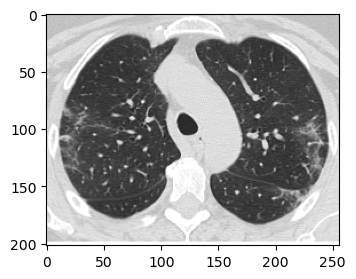

In [87]:
def read_img(filepath):
    return imread(os.path.join(train_dir, filepath))

img = read_img('COVID/Covid (1).png')
plt.figure(figsize=(7,3))
plt.imshow(img)

In [95]:
IMAGE_SIZE = 64

def resize_img(image_path, img_size):
    """Read and resize image using PIL instead of cv2."""
    img = Image.open(os.path.join(data_dir, image_path)).convert('RGB')
    img = img.resize((img_size, img_size), Image.Resampling.LANCZOS)
    return np.array(img) / 255.0  # normalize pixel values to [0, 1]


# ✅ Create empty array for storing images
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

# ✅ Loop through all image paths in your train DataFrame
for i, file in tqdm(enumerate(train['File']), total=len(train)):
    try:
        X_train[i] = resize_img(file, IMAGE_SIZE)
    except Exception as e:
        print(f"⚠️ Error reading {file}: {e}")


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2481/2481 [02:46<00:00, 14.89it/s]


In [227]:
# X_train.shape

In [100]:
X_train = X_train / 255
# X_train

In [231]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

# Y_train

### 3) Split the Dataset into Train/Validation

   * Split into Train, Validation datasets
   * Select split percentage & random state accordingly

In [230]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

### 4) Define Model Architecture

  * We are going to import three different architectures listed below :
      * VGG16
      * ResNet50
      * Xception
  * Structure of Model Architecture
      * Conv2D of Input Shape (3,3)
      * ResNet50/Xception/VGG16 Architecture
      * Add a GlobalAveragePooling2D()
      * Add a Dropout Layer
      * Final DenseNet Layer with relu activation
      * For Multiple Output add a Softmax layer
  * Use an 'adam' optimizer, hyperparameters can be tuned accordingly
  * The following code proposes a sample code for building a model

In [148]:
def build_model():
    SIZE = 64
    N_ch = 3

    # ✅ Choose ONE of these
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, N_ch))
    # base_model = Xception(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, N_ch))
    # base_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, N_ch))

    base_model.trainable = False

    input_layer = Input(shape=(SIZE, SIZE, N_ch))
    x = base_model(input_layer)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.003),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

### 5) Train the Model

   * Call build_model() function
   * Use an annealer, a callback that monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.
   * Use an ImageDataGenerator to carry out real time image data augmentation
   * Train the model on x_train, y_train
   * Save the model weights in .hdf5 format and model graph in .json format

In [152]:
# Choose one
hdf5_save = 'ResNet50_Model.keras'
# hdf5_save = 'Xception_Model.keras'
# hdf5_save = 'VGG16_Model.keras'

model = build_model()   # ✅ Correct spelling (not biuld_model)

annuler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.7,
    patience=5,
    verbose=1,
    min_lr=1e-4
)

checkpoint = ModelCheckpoint(hdf5_save, verbose=1, save_best_only=True)

In [2]:
# y_pred = model.predict(x_test)

# Building the Web App
   * Create a Django Project with an application initialized inside it which would be using the saved model weights to predict uploaded Chest X-Ray Images
   * Create a basic Static Page with a form to send the image file to the backend

In [217]:
from IPython.display import display, HTML

display(HTML('''
<form method="post" id="imageForm" enctype="multipart/form-data">
   {% csrf_token %}
   <label for="ImgFile">Upload Image</label>
   <input type="file" name="ImgFile" class="form-control"/>
   <input type="submit" id="submitButton" class="btn" name="submit" value="Solve"/>
</form>
'''))